# Final Project: Tweet Sentiment Analysis
by Noah McLean, Sunya Mohammed, and Neil Shah

For our final project, we trained a model to embed tweets as vectors, and then use those embeddings to train a supervised classification model for sentiment analysis for tweets. Using the sentiment analysis model, we looked for patterns in tweets about Nintendo that lined up with the announcement and release of the character Sephiroth for *Super Smash Bros. Ultimate*. Prior to the announcement of Sephiroth, Nintendo had issued a cease and desist to *The Big House*, a prominent *Super Smash Bros.* tournament series. This cease and desist generated a large amount of negative attention towards Nintendo on Twitter just prior to Sephiroth's announcement. We aimed to observe the sustained impact of the introduction of Sephiroth on the sentiment of the replies to all of Nintendo's tweets following the cease and desist. We hypothesized that the announcement of characters carries wave of positive sentiment through to Nintendo's future tweets for a short time.

More broadly, however, we aim to show that the classification model trained on embeddings can be used on similar datasets (besides Nintendo) in real time to observe the impact an action by a business or individual has on the overall public sentiment towards that specific entity.

Further reading available on *The Big House*:
https://upcomer.com/the-big-house-online-canceled-due-to-nintendo-cease-and-desist

## Part 1: Loading and Preprocessing Training Data

In [1]:
import warnings
import pandas as pd

warnings.filterwarnings("ignore")

tweets_df = pd.read_csv("./data/training.1600000.processed.noemoticon.csv", names= ['sentiment', 'id', 'time', 'flag', 'user', 'tweet'])
tweets_df.to_csv('twitter.csv', index= True)
print(tweets_df.columns)
display(tweets_df.head())

Index(['sentiment', 'id', 'time', 'flag', 'user', 'tweet'], dtype='object')


,sentiment,id,time,flag,user,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


The data we chose to train the first model to embed the tweets as vectors is a set of 1.6 million tweets sourced from [Kaggle](https://www.kaggle.com/datasets/kazanova/sentiment140). This dataset contains pre-labeled sentiment for all 1.6 million tweets, making it a prime choice for the training of a classifier. The sheer volume of tweets can help improve accuracy, which is vital considering the complexity of the task.

This dataset contains information about the sentiment, the time, the user, and the body of the tweet.

In [2]:
tweets_df = tweets_df[['tweet', 'sentiment']]
MAP = {0: "NEG", 4: "POS"}
tweets_df["sentiment"] = tweets_df.sentiment.map(MAP)

print('The dataset consists of {} features & {} samples.'.format(tweets_df.shape[1], tweets_df.shape[0]))
print('\nThe dataset has {} missing values.\n'.format(tweets_df.isnull().any(axis = 1).sum()))
display(tweets_df.head())

The dataset consists of 2 features & 1600000 samples.

The dataset has 0 missing values.



,tweet,sentiment
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",NEG
1,is upset that he can't update his Facebook by ...,NEG
2,@Kenichan I dived many times for the ball. Man...,NEG
3,my whole body feels itchy and like its on fire,NEG
4,"@nationwideclass no, it's not behaving at all....",NEG


The only two columns we needed from the database of tweets was the actual text of the tweet, along with the labeled sentiment. All other columns were dropped.

Furthermore, there were no missing values from the two columns we were interested in, meaning no handling for missing data needed to be done. This is likely due to the nature of the data; tweets are normally scraped, and all fields (time, user, tweet, etc.) are, by necessity, always available.

In [3]:
from tqdm import tqdm
from gensim.utils import simple_preprocess
import re
from os.path import exists
import nltk
from nltk.corpus import stopwords

nltk.download("stopwords")

def text_preprocessing(s):
    s = s.lower()
    s = re.sub(r"\'t", " not", s)
    s = re.sub(r'(@.*?)[\s]', ' ', s)
    s = re.sub(r'([\'\"\.\(\)\!\?\\\/\,])', r' \1 ', s)
    s = re.sub(r'[^\w\s\?]', ' ', s)
    s = re.sub(r'([\;\:\|•«\n])', ' ', s)
    s = " ".join([word for word in s.split()
                  if word not in stopwords.words('english')
                  or word in ['not', 'can']])
    s = re.sub(r'\s+', ' ', s).strip()

    return s

if not exists('./data/tokenized_data.csv'):
    print("Processing data")
    tweets_df['tokenized_tweet'] = tweets_df['tweet']
    for index, tweet in enumerate(tqdm(tweets_df.iterrows(), total= 1600000)):
        tweets_df.at[index, 'tokenized_tweet'] = text_preprocessing(tweets_df.at[index, 'tweet'])
        tweets_df.at[index, 'tokenized_tweet'] = simple_preprocess(tweets_df.at[index, 'tokenized_tweet'], deacc= True)
    tweets_df.to_csv('./data/tokenized_data.csv')
else:
    print("Using already processed data")
    tweets_df = pd.read_csv("./data/tokenized_data.csv")

display(tweets_df.head())

[nltk_data] Downloading package stopwords to
[nltk_data]     /usr/local/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Using already processed data


,Unnamed: 0,tweet,sentiment,tokenized_tweet,stemmed_tokens
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",NEG,"['http', 'twitpic', 'com', 'zl', 'awww', 'bumm...","['http', 'twitpic', 'com', 'zl', 'awww', 'bumm..."
1,1,is upset that he can't update his Facebook by ...,NEG,"['upset', 'can', 'not', 'update', 'facebook', ...","['upset', 'can', 'not', 'updat', 'facebook', '..."
2,2,@Kenichan I dived many times for the ball. Man...,NEG,"['dived', 'many', 'times', 'ball', 'managed', ...","['dive', 'mani', 'time', 'ball', 'manag', 'sav..."
3,3,my whole body feels itchy and like its on fire,NEG,"['whole', 'body', 'feels', 'itchy', 'like', 'f...","['whole', 'bodi', 'feel', 'itchi', 'like', 'fi..."
4,4,"@nationwideclass no, it's not behaving at all....",NEG,"['not', 'behaving', 'mad', 'can', 'not', 'see']","['not', 'behav', 'mad', 'can', 'not', 'see']"


Here, we started the preprocessing of the tweets required to embed them. First, we made our own function to get rid of characters and sequences in each tweet that were unnecessary for sentiment analysis, remove stopwords (words like "a", "the", "is", etc.) besides "not" and "can", and reformat the string. Stopwords are removed because they do not contribute much to the sentiment of a given sentence, the obvious exceptions being "not" and "can", which is why we decided to keep those two words in. After the tweets are run through our text preprocessing, they were put through another preprocessing function to correctly identify tokens and break each tweet into a list of its tokens.

As a side note, the if-else statements are to use already processed data saved as checkpoints, since we did not want to wait an hour each time we decided to run the notebook. This technique is used throughout the notebook.

In [4]:
from nltk.stem import SnowballStemmer

if not exists('./data/tokenized_data.csv'):
    print("Processing data")
    tweets_df['stemmed_tokens'] = tweets_df['tokenized_tweet']
    for index, tweet in enumerate(tqdm(tweets_df.iterrows(), total= 1600000)):
        tweets_df.at[index, 'stemmed_tokens'] = [SnowballStemmer("english").stem(word) for word in tweets_df.at[index, 'tokenized_tweet']]
    tweets_df.to_csv('./data/tokenized_data.csv')
else:
    print("Using already processed data")
    tweets_df = pd.read_csv('./data/tokenized_data.csv')

display(tweets_df.head())

Using already processed data


,Unnamed: 0,tweet,sentiment,tokenized_tweet,stemmed_tokens
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",NEG,"['http', 'twitpic', 'com', 'zl', 'awww', 'bumm...","['http', 'twitpic', 'com', 'zl', 'awww', 'bumm..."
1,1,is upset that he can't update his Facebook by ...,NEG,"['upset', 'can', 'not', 'update', 'facebook', ...","['upset', 'can', 'not', 'updat', 'facebook', '..."
2,2,@Kenichan I dived many times for the ball. Man...,NEG,"['dived', 'many', 'times', 'ball', 'managed', ...","['dive', 'mani', 'time', 'ball', 'manag', 'sav..."
3,3,my whole body feels itchy and like its on fire,NEG,"['whole', 'body', 'feels', 'itchy', 'like', 'f...","['whole', 'bodi', 'feel', 'itchi', 'like', 'fi..."
4,4,"@nationwideclass no, it's not behaving at all....",NEG,"['not', 'behaving', 'mad', 'can', 'not', 'see']","['not', 'behav', 'mad', 'can', 'not', 'see']"


Next, we used a snowball stemmer to stem each token in each tweet. This was done to extract the root of each word before embedding the tweet; this processing makes the variation between similar tweets decrease, which in turn improves the functionality of embedding model.

## Part 2: Exploratory Data Analysis

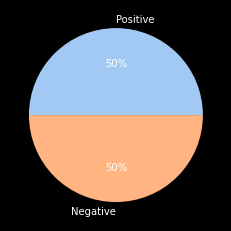

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style(rc= {'axes.facecolor': 'black',
                   'axes.edgecolor': 'white',
                   'axes.grid': False,
                   'axes.axisbelow': 'line',
                   'axes.labelcolor': 'white',
                   'figure.facecolor': 'black',
                   'grid.color': '#b0b0b0',
                   'grid.linestyle': '-',
                   'text.color': 'white',
                   'xtick.color': 'white',
                   'ytick.color': 'white',
                   'xtick.direction': 'out',
                   'ytick.direction': 'out',})

proportions = tweets_df['sentiment'].value_counts()
colors = sns.color_palette('pastel')[0:2]
plt.pie(proportions, labels= ['Positive', 'Negative'], colors= colors, autopct='%.0f%%')
plt.show()

Since this was the simple set of 1.6 million tweets, the only statistic of interest for us was the proportion of tweets with negative sentiment to tweets with positive sentiment. Since they were split evenly, we did not have to worry about bias in the data leaning in favor of one or the other later down the line.

## Part 3: Training and Using the Word2Vec Model

In [6]:
import multiprocessing
from gensim.models import Word2Vec
import time

size = 600
window = 3
min_count = 1
workers = multiprocessing.cpu_count()
sg = 1

word2vec_model_file = './models/' + 'word2vec_' + str(size) + '.model'

if not exists(word2vec_model_file):
    print("Model not found, a new model will be trained.")
    start_time = time.time()
    stemmed_tokens = pd.Series(tweets_df['stemmed_tokens']).values

    w2v_model = Word2Vec(stemmed_tokens, min_count= min_count, size= size, workers= workers, window= window, sg= sg)
    print("Time taken to train word2vec model: " + str(time.time() - start_time) + "seconds")
    w2v_model.save(word2vec_model_file)
else:
    print("Using pre-existing model: {}".format(word2vec_model_file))

Using pre-existing model: ./models/word2vec_600.model


The next step was to train the Word2Vec model for embedding the tweets. We decided to set the size of each vector to 600 dimensions to save on space without loosing to much in the way of information about the tweet. A higher number of dimensions is generally recommended for large datasets, according to [towardsdatascience](https://towardsdatascience.com/3-silver-bullets-of-word-embedding-in-nlp-10fa8f50cc5a). Window pertains to the maximum distance between the current and predicted word. Min_count specifies the lowest frequency of word accepted into the training; we wanted every word kept through our preprocessing to be used. Workers specifies the number of threads the function to train the model should employ. Finally, sg refers to the method used to train the model; 1 corresponds to skip-gram, while 0 corresponds to continuous bag of words. We opted to go for skip-gram because it better represents uncommon words, even though CBOW is faster, all according to [towardsdatascience](https://towardsdatascience.com/nlp-101-word2vec-skip-gram-and-cbow-93512ee24314).

The model is stored so that it does not need to be trained every time the notebook is run.

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(tweets_df['stemmed_tokens'], tweets_df['sentiment'], test_size= .3, random_state= 420)

X_train = X_train.reset_index()
X_test = X_test.reset_index()
Y_train = Y_train.to_frame()
Y_train = Y_train.reset_index()
Y_test = Y_test.to_frame()
Y_test = Y_test.reset_index()

display(X_train.head())

,index,stemmed_tokens
0,732210,"['finish', 'watch', 'monster', 'vs', 'alien', ..."
1,1125598,"['yes', 'inde', 'wooot', 'subo', 'gracious', '..."
2,1014391,"['happi', 'see', 'lot', 'new', 'familiar', 'fa..."
3,1131784,"['http', 'tinyurl', 'com', 'ry', 'wap', 'hi', ..."
4,580034,"['wanna', 'bubbl', 'bath', 'hard', 'shower']"


Now, we split the 1.6 million tweets into a train and test set so that we could find out the general accuracy of the model before applying it on other data. We went with the standard 70-30 split and used a random state so that the same data is selected for training and testing each time.

In [8]:
import numpy as np

sg_w2v_model = Word2Vec.load(word2vec_model_file)

word2vec_filename = './checkpoints/' + 'train_review_word2vec.csv'

if not exists(word2vec_filename):
    print("No embeddings found, new embeddings will be created")
    with open(word2vec_filename, 'w+') as word2vec_file:
        for index, row in tqdm(X_train.iterrows(), total= int(0.7 * 1600000)):
            model_vector = (np.mean([sg_w2v_model[token] for token in row['stemmed_tokens']], axis= 0)).tolist()
            if index == 0:
                header = ",".join(str(ele) for ele in range(600))
                word2vec_file.write(header)
                word2vec_file.write("\n")
            if type(model_vector) is list:
                line1 = ",".join( [str(vector_element) for vector_element in model_vector] )
            else:
                line1 = ",".join([str(0) for i in range(600)])

            word2vec_file.write(line1)
            word2vec_file.write('\n')
else:
    print("Existing embeddings found")

Existing embeddings found


The last step before training the classification model was embedding the sets as vectors. Here, we used the model we just trained, the Word2Vec model, to represent each tweet as a vector. Without getting into the fine details (because we do not understand the fine detail all that much), we can think of the vector as the numerical representation of the semantic meaning of the tweet.

This step was the most computationally expensive part of tthe project, so we wrote the vectors out to hard memory to save time.

In [9]:
word2vec_filename = './checkpoints/' + 'test_review_word2vec.csv'

if not exists(word2vec_filename):
    print("No embeddings found, new embeddings will be created")
    with open(word2vec_filename, 'w+') as word2vec_file:
        for index, row in tqdm(X_test.iterrows(), total= int(0.3 * 1600000)):
            model_vector = (np.mean([sg_w2v_model[token] for token in row['stemmed_tokens']], axis= 0)).tolist()
            if index == 0:
                header = ",".join(str(ele) for ele in range(600))
                word2vec_file.write(header)
                word2vec_file.write("\n")
            if type(model_vector) is list:
                line1 = ",".join( [str(vector_element) for vector_element in model_vector] )
            else:
                line1 = ",".join([str(0) for i in range(600)])

            word2vec_file.write(line1)
            word2vec_file.write('\n')
else:
    print("Existing embeddings found")

Existing embeddings found


Here, we do the same thing but for the test set; all 1.6 million tweets are now embedded as vectors. These vectors are interpretable by scikit-learn classifier models.

These vectors were also saved to memory.

## Part 4: Training a Stochastic Gradient Descent Linear Classifier (Word2Vec)

In [10]:
from sklearn.linear_model import SGDClassifier

chunk_size = 20000
Y_train = Y_train[['sentiment']]
Y_list = np.array_split(Y_train, 56, axis= 0)

i = 0
clf = SGDClassifier(alpha= .0001, loss= 'log', penalty= 'l2', n_jobs= workers, shuffle= True)
for train_df in tqdm(pd.read_csv("./checkpoints/train_review_word2vec.csv", chunksize= chunk_size, iterator= True), total= 56):
    X = train_df
    Y = Y_list[i]
    clf.partial_fit(X, Y.values.ravel(), classes= ['NEG', 'POS'])
    i += 1

100%|██████████| 56/56 [02:51<00:00,  3.07s/it]


For our classification model, we decided to go for an SGD linear classifier because it has the ability to train in mini-batches. The machine we ran this on only has 16GB of ram, which would make loading in all the vectors at once a bit too intensive. We also tried to explore cloud solutions, but we elected to stick with our own machines after some difficulty on that front. Like the name suggests, this model uses gradient descent to learn the parameters to a linear classifier. The difference between this model and others is that it allows for partial fit, which basically breaks the larger set into epochs for training.

Luckily, the model take about 5 minutes to train, which means we did not need to save it.

In [11]:
from sklearn.metrics import classification_report

Y_test = Y_test[['sentiment']]
test_df = pd.read_csv('./checkpoints/test_review_word2vec.csv')
Y_pred = clf.predict(test_df)
print(classification_report(Y_test,Y_pred, digits= 5))

              precision    recall  f1-score   support

         NEG    0.78927   0.72397   0.75521    239413
         POS    0.74622   0.80765   0.77572    240587

    accuracy                        0.76591    480000
   macro avg    0.76774   0.76581   0.76547    480000
weighted avg    0.76769   0.76591   0.76549    480000



This is the report for our classification model. Looking at the accuracy of 76%, we can tell that the model is not the greatest in the world (considering that 50% is the baseline for binary classification). That being said, with large enough quantities of data for the model to be applied to, we can still put together a decent understanding of the true overall public sentiment towards a given entity. Furthermore, there is potential for there to be tweets that are more neutral in sentiment, which can flip-flop either way. Since the original dataset did not have any observations labeled as 'neutral', we could not introduce a third class without going for a regressor, which would then give us an accuracy that was not completely interpretable, given that there are no neutrals in the test set.

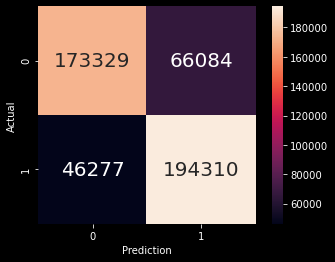

In [12]:
from sklearn.metrics import confusion_matrix

cm_knn = confusion_matrix(Y_test,Y_pred)
sns.heatmap(cm_knn, annot= True, annot_kws= {'size': 20}, square= True, fmt= ".0f")

plt.xlabel("Prediction")
plt.ylabel("Actual")
plt.show()

Here is a confusion matrix corresponding to the classifier where 1 corresponds to POS and 0 corresponds to NEG sentiment.

### Part 6: Obtaining Nintendo Tweets

With the model ready, it's time to actually gather tweets related to the cease and desist of the *The Big House* and Sephiroth's announcement. To do this we'll use Snscrape, a social media data scrapper. We'll scrape tweets based on two hashtags: *#FreeMelee* and *#SaveSmash*. These hashtags were used by the *Super Smash Bros.* esports community following the cease and desist notice to express contempt at Nintendo's actions. We'll also scrape overall mentions of Nintendo's American Twitter account. We'll scrape 25000 tweets for both hashtags and overall mentions. Since *The Big House* was canceled on November 19th, 2020, and Sephiroth's announcement was on December 10th, 2020, we'll limit our search within this timeframe. Furthermore, this timeframe is the reason why Snscrape was chosen over the official Twitter API, as it does not allow queries for tweets over seven days old.

In [13]:
import snscrape.modules.twitter as sntwitter #Importing Snscrape
import itertools

if not exists('./data/FreeMelee.txt'):
    print("New data will be scraped")
    search = '#FreeMelee -filter:retweets since:2020-11-22 until:2020-12-28 lang:en' #The query we're providing Snscrape to query the #FreeMelee hashtag.
    free_melee_df = pd.DataFrame(itertools.islice(sntwitter.TwitterSearchScraper(search).get_items(), 25000)) #Storing the scraped tweets in a DataFrame.
    free_melee_df.to_csv('./data/FreeMelee.txt', index= False, sep= '\t') #Saving the DataFrame to a .csv for future use.
else: #Checking if the computer running the code already has already queried before. Helps lower runtime.
    print("Using already scraped data")
    free_melee_df = pd.read_csv('./data/FreeMelee.txt', sep= "\t")

display(free_melee_df.head()) #Now let's see what our scraped tweets look like.

Using already scraped data


,url,date,content,renderedContent,id,user,replyCount,retweetCount,likeCount,quoteCount,...,media,retweetedTweet,quotedTweet,inReplyToTweetId,inReplyToUser,mentionedUsers,coordinates,place,hashtags,cashtags
0,https://twitter.com/astrelos/status/1343343676...,2020-12-27 23:51:05+00:00,@BTSsmash Inb4 it gets shut down because of Ni...,@BTSsmash Inb4 it gets shut down because of Ni...,1.343340e+18,"{'username': 'astrelos', 'id': 747822644121198...",0,0,0,0,...,NaN,NaN,NaN,1.340000e+18,"{'username': 'BTSsmash', 'id': 844995008474202...","[{'username': 'BTSsmash', 'id': 84499500847420...",NaN,NaN,"['freemelee', 'savesmash']",NaN
1,https://twitter.com/Gr4de_/status/134334251096...,2020-12-27 23:46:27+00:00,I just had this video pop up on my YT-recommen...,I just had this video pop up on my YT-recommen...,1.343340e+18,"{'username': 'Gr4de_', 'id': 10853067100828876...",1,0,1,0,...,NaN,NaN,{'url': 'https://twitter.com/NocturnalFudj/sta...,NaN,NaN,NaN,NaN,NaN,['FreeMelee'],NaN
2,https://twitter.com/The_Fostered/status/134333...,2020-12-27 23:36:27+00:00,@summit1g Nintendo is still the greatest.\n@Tr...,@summit1g Nintendo is still the greatest.\n@Tr...,1.343340e+18,"{'username': 'The_Fostered', 'id': 12092850143...",0,0,0,0,...,NaN,NaN,NaN,1.340000e+18,"{'username': 'summit1g', 'id': 1708443876, 'di...","[{'username': 'summit1g', 'id': 1708443876, 'd...",NaN,NaN,['FreeMelee'],NaN
3,https://twitter.com/brazmonkee/status/13433382...,2020-12-27 23:29:29+00:00,Doubles &gt;&gt;&gt;&gt; #FreeMelee https://t....,Doubles &gt;&gt;&gt;&gt; #FreeMelee https://t....,1.343340e+18,"{'username': 'brazmonkee', 'id': 381107394, 'd...",0,0,3,0,...,[{'thumbnailUrl': 'https://pbs.twimg.com/ext_t...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,['FreeMelee'],NaN
4,https://twitter.com/vaheeeezy/status/134333789...,2020-12-27 23:28:06+00:00,Grindin' like a stripper today\nSmash Ultimate...,Grindin' like a stripper today\nSmash Ultimate...,1.343340e+18,"{'username': 'vaheeeezy', 'id': 2187936307, 'd...",0,3,5,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"['freemelee', 'savesmash', 'smallstreamer', 't...",NaN


In [14]:
if not exists('./data/SaveSmash.txt'):
    print("New data will be scraped")
    search = '#SaveSmash -filter:retweets since:2020-11-22 until:2020-12-28 lang:en' #The query we're providing Snscrape to query the #SaveSmash hashtag.
    save_smash_df = pd.DataFrame(itertools.islice(sntwitter.TwitterSearchScraper(search).get_items(), 25000)) #Putting the #SaveSmash query in a DataFrame.
    save_smash_df.to_csv('./data/SaveSmash.txt', index= False, sep= "\t") #Saving the DataFrame to a .csv file.
else:
    print("Using already scraped data")
    save_smash_df = pd.read_csv('./data/SaveSmash.txt', sep= "\t")

display(save_smash_df.head())

Using already scraped data


,url,date,content,renderedContent,id,user,replyCount,retweetCount,likeCount,quoteCount,...,media,retweetedTweet,quotedTweet,inReplyToTweetId,inReplyToUser,mentionedUsers,coordinates,place,hashtags,cashtags
0,https://twitter.com/astrelos/status/1343343676...,2020-12-27 23:51:05+00:00,@BTSsmash Inb4 it gets shut down because of Ni...,@BTSsmash Inb4 it gets shut down because of Ni...,1.343340e+18,"{'username': 'astrelos', 'id': 747822644121198...",0,0,0,0,...,NaN,NaN,NaN,1.340000e+18,"{'username': 'BTSsmash', 'id': 844995008474202...","[{'username': 'BTSsmash', 'id': 84499500847420...",NaN,NaN,"['freemelee', 'savesmash']",NaN
1,https://twitter.com/ScrupleHD/status/134334111...,2020-12-27 23:40:54+00:00,Did anyone else think it was so insane that Sa...,Did anyone else think it was so insane that Sa...,1.343340e+18,"{'username': 'ScrupleHD', 'id': 12951044307366...",1,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,['SaveSmash'],NaN
2,https://twitter.com/Vigilante_Blade/status/134...,2020-12-27 23:28:31+00:00,I will say... the new trend of people treating...,I will say... the new trend of people treating...,1.343340e+18,"{'username': 'Vigilante_Blade', 'id': 24971159...",1,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,['SaveSmash'],NaN
3,https://twitter.com/vaheeeezy/status/134333789...,2020-12-27 23:28:06+00:00,Grindin' like a stripper today\nSmash Ultimate...,Grindin' like a stripper today\nSmash Ultimate...,1.343340e+18,"{'username': 'vaheeeezy', 'id': 2187936307, 'd...",0,3,5,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"['freemelee', 'savesmash', 'smallstreamer', 't...",NaN
4,https://twitter.com/EddyMexico007/status/13433...,2020-12-27 23:21:08+00:00,"I will stream at 4:30pm PT, my tournament run ...","I will stream at 4:30pm PT, my tournament run ...",1.343340e+18,"{'username': 'EddyMexico007', 'id': 2700120234...",0,0,2,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"['FreeMelee', 'SaveSmash']",NaN


In [15]:
if not exists('./data/Mentions.txt'):
    print("New data will be scraped")
    search = '@NintendoAmerica -filter:retweets since:2020-11-22 until:2020-12-28 lang:en' #The query we're providing Snscrape to query overall mentions.
    mentions_df = pd.DataFrame(itertools.islice(sntwitter.TwitterSearchScraper(search).get_items(), 25000))
    mentions_df.to_csv('./data/Mentions.txt', index= False, sep= "\t")
else:
    print("Using already scraped data")
    mentions_df = pd.read_csv('./data/Mentions.txt', sep= "\t")

display(mentions_df.head())

Using already scraped data


,url,date,content,renderedContent,id,user,replyCount,retweetCount,likeCount,quoteCount,...,media,retweetedTweet,quotedTweet,inReplyToTweetId,inReplyToUser,mentionedUsers,coordinates,place,hashtags,cashtags
0,https://twitter.com/PhellaDaFam/status/1343344...,2020-12-27 23:54:24+00:00,@joepapadon @Nintendo They'll come back around...,@joepapadon @Nintendo They'll come back around...,1.343340e+18,"{'username': 'PhellaDaFam', 'id': 1053014802, ...",0,0,2,0,...,NaN,NaN,NaN,1.340000e+18,"{'username': 'joepapadon', 'id': 1239033279619...","[{'username': 'joepapadon', 'id': 123903327961...",NaN,NaN,NaN,NaN
1,https://twitter.com/notBoomerTery/status/13433...,2020-12-27 23:53:18+00:00,@nintendo nuke my house https://t.co/t5zBBdmCyI,@nintendo nuke my house https://t.co/t5zBBdmCyI,1.343340e+18,"{'username': 'notBoomerTery', 'id': 1173773387...",0,0,0,0,...,[{'previewUrl': 'https://pbs.twimg.com/media/E...,NaN,NaN,NaN,NaN,"[{'username': 'Nintendo', 'id': 307902310, 'di...",NaN,NaN,NaN,NaN
2,https://twitter.com/alvinSeven77/status/134334...,2020-12-27 23:44:46+00:00,@kimbal Hehe nice Tesla is really a mobile con...,@kimbal Hehe nice Tesla is really a mobile con...,1.343340e+18,"{'username': 'alvinSeven77', 'id': 309530329, ...",0,0,1,0,...,NaN,NaN,NaN,1.340000e+18,"{'username': 'kimbal', 'id': 4767021, 'display...","[{'username': 'kimbal', 'id': 4767021, 'displa...",NaN,NaN,NaN,NaN
3,https://twitter.com/TehParalyzer/status/134334...,2020-12-27 23:39:32+00:00,@DigitalEmelas @Dotemu @nihonfalcom @Xbox @Nin...,@DigitalEmelas @Dotemu @nihonfalcom @Xbox @Nin...,1.343340e+18,"{'username': 'TehParalyzer', 'id': 46956704, '...",0,0,0,0,...,NaN,NaN,NaN,1.340000e+18,"{'username': 'DigitalEmelas', 'id': 8876548010...","[{'username': 'DigitalEmelas', 'id': 887654801...",NaN,NaN,NaN,NaN
4,https://twitter.com/GhostDiamond13/status/1343...,2020-12-27 23:29:38+00:00,@GamesWithToasty @DigitalEmelas @Dotemu @nihon...,@GamesWithToasty @DigitalEmelas @Dotemu @nihon...,1.343340e+18,"{'username': 'GhostDiamond13', 'id': 912019048...",1,0,3,0,...,NaN,NaN,NaN,1.340000e+18,"{'username': 'GamesWithToasty', 'id': 10815867...","[{'username': 'GamesWithToasty', 'id': 1081586...",NaN,NaN,NaN,NaN


### Part 7: Exploratory Data Analysis (Nintendo)

Now that we have our tweets in DataFrames, lets get a feel for the data. We'll start by demonstrating just how significant Sephiroth's inclusion in the game was in the *Super Smash Bros.* community. To do this, we'll look at the
views for each downloadable content character's announcement. More specifically, we'll compare the views each character's reveal trailer has on YouTube only on the official Nintendo YouTube account.

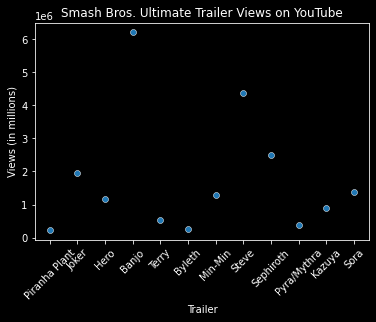

In [16]:
#Since there was only 12 downloadable content characters. We'll just copy the views for each character's reveal into variables corresponding to their names.
plant = 230240
joker = 1962614
hero = 1158874
banjo = 6194663
terry = 545481
byleth = 258581
minmin = 1291760
steve = 4373165
sephiroth = 2484194
pyra = 375344
kazuya = 888845
sora = 1387712

dlc_chars = np.array([plant, joker, hero, banjo, terry, byleth, minmin, steve, sephiroth, pyra, kazuya, sora]) #Putting all the view counts into an array to plot each character's views.

#Plotting
trailer_num_lst = [i for i in range(12)]
plot = sns.scatterplot(x = range(12), y = dlc_chars).set(title= "Smash Bros. Ultimate Trailer Views on YouTube", xlabel= "Trailer", ylabel= "Views (in millions)")
plt.xticks(trailer_num_lst, ['Piranha Plant', 'Joker', 'Hero', 'Banjo', 'Terry', 'Byleth', 'Min-Min', 'Steve', 'Sephiroth', 'Pyra/Mythra', 'Kazuya', 'Sora'])
plt.xticks(rotation= 45)

plt.show()

In [17]:
print("Median Views: {}".format(np.median(dlc_chars)))

Median Views: 1225317.0


So while Sephiroth wasn't the character who's announcement garnered the most views overall, the view count associated with Sephiroth's trailer is certainly higher than the average and can be considered a significant event in the *Super Smash Bros.* community.

Next we'll compare the frequency of the *#SaveSmash* and *#FreeMelee* hashtags. While they both were used to convey the same meaning on Twitter, it will be insightful to observe which hashtag was most prevalent during this period. We'll do this by concatenating the DataFrames for both hashtags

In [18]:
all_hashtags_df = pd.concat([save_smash_df, free_melee_df]) #Concatenating the DataFrames for the hashtags together.
all_hashtags_df = all_hashtags_df.drop_duplicates(subset= ['content']) #Dropping any duplicate tweets.

#Now let's see how big this concatenated DataFrame is.
print('Observations in dataset: ', all_hashtags_df.shape[0])

display(all_hashtags_df.head())

Observations in dataset:  32605


,url,date,content,renderedContent,id,user,replyCount,retweetCount,likeCount,quoteCount,...,media,retweetedTweet,quotedTweet,inReplyToTweetId,inReplyToUser,mentionedUsers,coordinates,place,hashtags,cashtags
0,https://twitter.com/astrelos/status/1343343676...,2020-12-27 23:51:05+00:00,@BTSsmash Inb4 it gets shut down because of Ni...,@BTSsmash Inb4 it gets shut down because of Ni...,1.343340e+18,"{'username': 'astrelos', 'id': 747822644121198...",0,0,0,0,...,NaN,NaN,NaN,1.340000e+18,"{'username': 'BTSsmash', 'id': 844995008474202...","[{'username': 'BTSsmash', 'id': 84499500847420...",NaN,NaN,"['freemelee', 'savesmash']",NaN
1,https://twitter.com/ScrupleHD/status/134334111...,2020-12-27 23:40:54+00:00,Did anyone else think it was so insane that Sa...,Did anyone else think it was so insane that Sa...,1.343340e+18,"{'username': 'ScrupleHD', 'id': 12951044307366...",1,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,['SaveSmash'],NaN
2,https://twitter.com/Vigilante_Blade/status/134...,2020-12-27 23:28:31+00:00,I will say... the new trend of people treating...,I will say... the new trend of people treating...,1.343340e+18,"{'username': 'Vigilante_Blade', 'id': 24971159...",1,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,['SaveSmash'],NaN
3,https://twitter.com/vaheeeezy/status/134333789...,2020-12-27 23:28:06+00:00,Grindin' like a stripper today\nSmash Ultimate...,Grindin' like a stripper today\nSmash Ultimate...,1.343340e+18,"{'username': 'vaheeeezy', 'id': 2187936307, 'd...",0,3,5,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"['freemelee', 'savesmash', 'smallstreamer', 't...",NaN
4,https://twitter.com/EddyMexico007/status/13433...,2020-12-27 23:21:08+00:00,"I will stream at 4:30pm PT, my tournament run ...","I will stream at 4:30pm PT, my tournament run ...",1.343340e+18,"{'username': 'EddyMexico007', 'id': 2700120234...",0,0,2,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"['FreeMelee', 'SaveSmash']",NaN


To compare the frequency of each hashtag, we'll create a bar graph where each bar corresponds to one of three possibilities: Tweets that contain the *#SaveSmash* hashtag, tweets that contain the *#FreeMelee* hashtag, and tweets that contain both hashtags. To do this, we'll create a new column in the DataFrame we concatenated earlier called Hashtag Code that we'll update while iterating through the DataFrame.

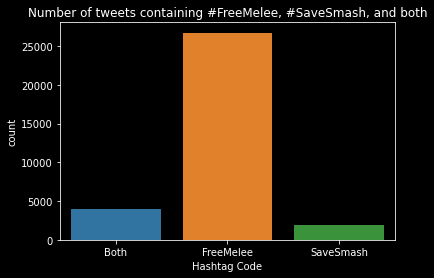

In [19]:
all_hashtags_df['Hashtag Code'] = 'NaN' #Creating the new column in the DataFrame.

#Iterating through the DataFrame.
for curr_index, curr_row in all_hashtags_df.iterrows():
    curr_tweet = str.lower(curr_row[2]) #Converting whatever tweet we're looking at to all lowercase to avoid casing issues.

    if '#savesmash' in curr_tweet and '#freemelee' in curr_tweet:
        all_hashtags_df.at[curr_index, 'Hashtag Code'] = 'Both'

    elif '#savesmash' in curr_tweet and '#freemelee' not in curr_tweet:
        all_hashtags_df.at[curr_index, 'Hashtag Code'] = 'SaveSmash'

    else:
        all_hashtags_df.at[curr_index, 'Hashtag Code'] = 'FreeMelee'

#Plotting
sns.countplot(x= 'Hashtag Code', data= all_hashtags_df)
plt.title("Number of tweets containing #FreeMelee, #SaveSmash, and both")
plt.show()

So it seems that the *#FreeMelee* hashtag was most frequent among the tweets we scraped. This makes sense, as the cease and desist order from Nintendo was specifically targeted at *Super Smash Bros. Melee*. We'll keep this in mind later when creating other plots.

Finally let's look at the frequency of each hashtag over time, as well as overall mentions. This will require wrangling a bit more intensive than the previous frequency plot. We'll start by making 1/0 columns in the concatenated hashtags DataFrame for each hashtag possibility. Note that due to the nature of the previous queries, there shouldn't actually be any tweets that contain neither hashtag.

In [20]:
all_hashtags_df['SaveSmash and FreeMelee'] = ['#savesmash' in curr.lower() and '#freesmash' in curr.lower() for curr in all_hashtags_df['content']] #Creating a 1/0 column for tweets that contain both hashtags.

all_hashtags_df['SaveSmash'] = ['#savesmash' in curr.lower() and '#freemelee' not in curr.lower() for curr in all_hashtags_df['content']] #Creating a 1/0 column for only #SaveSmash tweets.

all_hashtags_df['FreeMelee'] = ['#freemelee' in curr.lower() and '#savesmash' not in curr.lower() for curr in all_hashtags_df['content']] #Creating a 1/0 column for only #FreeMelee tweets.

all_hashtags_df['Other Hashtags'] = ['#savesmash' not in curr.lower() and '#freemelee' not in curr.lower() for curr in all_hashtags_df['content']] #Creating a 1/0 column for tweets that contain neither hashtag.

display(mentions_df.head()) #Displaying DataFrame with new columns.

,url,date,content,renderedContent,id,user,replyCount,retweetCount,likeCount,quoteCount,...,media,retweetedTweet,quotedTweet,inReplyToTweetId,inReplyToUser,mentionedUsers,coordinates,place,hashtags,cashtags
0,https://twitter.com/PhellaDaFam/status/1343344...,2020-12-27 23:54:24+00:00,@joepapadon @Nintendo They'll come back around...,@joepapadon @Nintendo They'll come back around...,1.343340e+18,"{'username': 'PhellaDaFam', 'id': 1053014802, ...",0,0,2,0,...,NaN,NaN,NaN,1.340000e+18,"{'username': 'joepapadon', 'id': 1239033279619...","[{'username': 'joepapadon', 'id': 123903327961...",NaN,NaN,NaN,NaN
1,https://twitter.com/notBoomerTery/status/13433...,2020-12-27 23:53:18+00:00,@nintendo nuke my house https://t.co/t5zBBdmCyI,@nintendo nuke my house https://t.co/t5zBBdmCyI,1.343340e+18,"{'username': 'notBoomerTery', 'id': 1173773387...",0,0,0,0,...,[{'previewUrl': 'https://pbs.twimg.com/media/E...,NaN,NaN,NaN,NaN,"[{'username': 'Nintendo', 'id': 307902310, 'di...",NaN,NaN,NaN,NaN
2,https://twitter.com/alvinSeven77/status/134334...,2020-12-27 23:44:46+00:00,@kimbal Hehe nice Tesla is really a mobile con...,@kimbal Hehe nice Tesla is really a mobile con...,1.343340e+18,"{'username': 'alvinSeven77', 'id': 309530329, ...",0,0,1,0,...,NaN,NaN,NaN,1.340000e+18,"{'username': 'kimbal', 'id': 4767021, 'display...","[{'username': 'kimbal', 'id': 4767021, 'displa...",NaN,NaN,NaN,NaN
3,https://twitter.com/TehParalyzer/status/134334...,2020-12-27 23:39:32+00:00,@DigitalEmelas @Dotemu @nihonfalcom @Xbox @Nin...,@DigitalEmelas @Dotemu @nihonfalcom @Xbox @Nin...,1.343340e+18,"{'username': 'TehParalyzer', 'id': 46956704, '...",0,0,0,0,...,NaN,NaN,NaN,1.340000e+18,"{'username': 'DigitalEmelas', 'id': 8876548010...","[{'username': 'DigitalEmelas', 'id': 887654801...",NaN,NaN,NaN,NaN
4,https://twitter.com/GhostDiamond13/status/1343...,2020-12-27 23:29:38+00:00,@GamesWithToasty @DigitalEmelas @Dotemu @nihon...,@GamesWithToasty @DigitalEmelas @Dotemu @nihon...,1.343340e+18,"{'username': 'GhostDiamond13', 'id': 912019048...",1,0,3,0,...,NaN,NaN,NaN,1.340000e+18,"{'username': 'GamesWithToasty', 'id': 10815867...","[{'username': 'GamesWithToasty', 'id': 1081586...",NaN,NaN,NaN,NaN


Let's just make sure that there aren't any tweets in that contain neither hashtag real quick.

In [21]:
print(all_hashtags_df['Other Hashtags'].value_counts())

False    32604
True         1
Name: Other Hashtags, dtype: int64


Well, somehow a suspended account's tweet made it into our DataFrame, let's just drop that since it holds no relevance to our project.

In [22]:
all_hashtags_df.drop([2210]) #Dropping bad tweet.

,url,date,content,renderedContent,id,user,replyCount,retweetCount,likeCount,quoteCount,...,mentionedUsers,coordinates,place,hashtags,cashtags,Hashtag Code,SaveSmash and FreeMelee,SaveSmash,FreeMelee,Other Hashtags
0,https://twitter.com/astrelos/status/1343343676...,2020-12-27 23:51:05+00:00,@BTSsmash Inb4 it gets shut down because of Ni...,@BTSsmash Inb4 it gets shut down because of Ni...,1.343340e+18,"{'username': 'astrelos', 'id': 747822644121198...",0,0,0,0,...,"[{'username': 'BTSsmash', 'id': 84499500847420...",NaN,NaN,"['freemelee', 'savesmash']",NaN,Both,False,False,False,False
1,https://twitter.com/ScrupleHD/status/134334111...,2020-12-27 23:40:54+00:00,Did anyone else think it was so insane that Sa...,Did anyone else think it was so insane that Sa...,1.343340e+18,"{'username': 'ScrupleHD', 'id': 12951044307366...",1,0,1,0,...,NaN,NaN,NaN,['SaveSmash'],NaN,FreeMelee,False,True,False,False
2,https://twitter.com/Vigilante_Blade/status/134...,2020-12-27 23:28:31+00:00,I will say... the new trend of people treating...,I will say... the new trend of people treating...,1.343340e+18,"{'username': 'Vigilante_Blade', 'id': 24971159...",1,0,1,0,...,NaN,NaN,NaN,['SaveSmash'],NaN,FreeMelee,False,True,False,False
3,https://twitter.com/vaheeeezy/status/134333789...,2020-12-27 23:28:06+00:00,Grindin' like a stripper today\nSmash Ultimate...,Grindin' like a stripper today\nSmash Ultimate...,1.343340e+18,"{'username': 'vaheeeezy', 'id': 2187936307, 'd...",0,3,5,0,...,NaN,NaN,NaN,"['freemelee', 'savesmash', 'smallstreamer', 't...",NaN,FreeMelee,False,False,False,False
4,https://twitter.com/EddyMexico007/status/13433...,2020-12-27 23:21:08+00:00,"I will stream at 4:30pm PT, my tournament run ...","I will stream at 4:30pm PT, my tournament run ...",1.343340e+18,"{'username': 'EddyMexico007', 'id': 2700120234...",0,0,2,1,...,NaN,NaN,NaN,"['FreeMelee', 'SaveSmash']",NaN,Both,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24987,https://twitter.com/Theblockman_ssb/status/133...,2020-11-25 01:45:27+00:00,@Sora_Sakurai Love your work sakurai and I kno...,@Sora_Sakurai Love your work sakurai and I kno...,1.331410e+18,"{'username': 'Theblockman_ssb', 'id': 13266707...",0,0,0,0,...,"[{'username': 'Sora_Sakurai', 'id': 200965355,...",NaN,NaN,"['FreeMelee', 'FreeSmash']",NaN,FreeMelee,False,False,True,False
24988,https://twitter.com/Mora_BOTW/status/133141362...,2020-11-25 01:45:19+00:00,"@NintendoUK #FreeMelee \nOh boy, I want to can...","@NintendoUK #FreeMelee \nOh boy, I want to can...",1.331410e+18,"{'username': 'Mora_BOTW', 'id': 13299522685993...",0,0,0,0,...,"[{'username': 'NintendoUK', 'id': 493974431, '...",NaN,NaN,['FreeMelee'],NaN,FreeMelee,False,False,True,False
24991,https://twitter.com/thenickbros/status/1331413...,2020-11-25 01:43:33+00:00,@NintendoAmerica Not as fun as #Freemelee cmon...,@NintendoAmerica Not as fun as #Freemelee cmon...,1.331410e+18,"{'username': 'thenickbros', 'id': 103606453913...",0,0,1,0,...,"[{'username': 'NintendoAmerica', 'id': 5162861...",NaN,NaN,['Freemelee'],NaN,FreeMelee,False,False,True,False
24993,https://twitter.com/ItzGreek/status/1331412985...,2020-11-25 01:42:46+00:00,Its been a few days so #FreeMelee #SaveMelee,Its been a few days so #FreeMelee #SaveMelee,1.331410e+18,"{'username': 'ItzGreek', 'id': 566856193, 'dis...",0,2,5,0,...,NaN,NaN,NaN,"['FreeMelee', 'SaveMelee']",NaN,FreeMelee,False,False,True,False


In order to plot over the dates of each tweet, we added a new column that extracts the year, month and date from the date column and group the dataframe by this new column. Then, we counted the occurrences of each hashtag over each group and finally created a line plot that plots each hashtag over time.

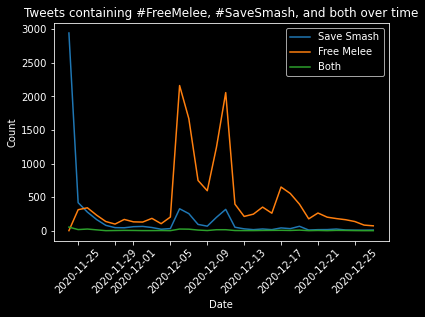

In [23]:
import datetime

# Use the datetime library to add a day column to the frame
all_hashtags_df["day"] = all_hashtags_df["date"].apply(lambda x: datetime.datetime.strptime(str(x)[0:10], "%Y-%m-%d"))
# Group the tweets by the day they were posted
groups = all_hashtags_df.groupby('day')

# Count the occurrences of tweets with the hashtags for each day
both_count = groups['SaveSmash and FreeMelee'].sum()
save_smash_count = groups['SaveSmash'].sum()
free_melee_count = groups['FreeMelee'].sum()

# Get the list of days from the groupby output
dates = both_count.index.tolist()

# Plot each lineplot
sns.lineplot(y= save_smash_count.tolist(), x= dates)
sns.lineplot(y= free_melee_count.tolist(), x= dates)
sns.lineplot(y= both_count.tolist(), x= dates)
plt.xticks(rotation= 45)
plt.legend(labels= ["Save Smash","Free Melee", "Both"])
plt.title("Tweets containing #FreeMelee, #SaveSmash, and both over time")
plt.xlabel("Date")
plt.ylabel("Count")
plt.show()

This plot shows the frequency of tweets for each hashtag over the time interval that we chose. We can see that the quantity of tweets was high on average in November following the cease and desist news, then dropped for several weeks, and then increased again at the beginning of December, particularly the #FreeMelee tweets, following the Sephiroth announcement.
We also created a plot for the tweets over time that contained @Nintendo mentions.

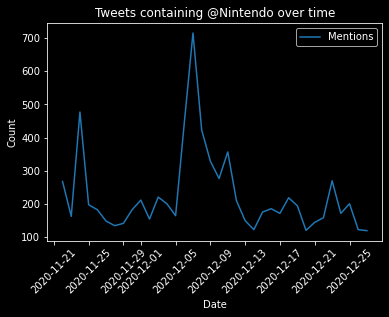

In [24]:
# Create a day column
mentions_df["day"] = mentions_df["date"].apply(lambda x: datetime.datetime.strptime(str(x)[0:10], "%Y-%m-%d"))
# Group by day
groups = mentions_df.groupby('day')
mention_count = groups['content'].count()

dates = mention_count.index.tolist()

# Plot the mentions over time
sns.lineplot(y= mention_count.tolist(), x= dates)
plt.legend(labels= ["Mentions"])
plt.xticks(rotation= 45)
plt.title("Tweets containing @Nintendo over time")
plt.xlabel("Date")
plt.ylabel("Count")

plt.show()

This plot shows a similar trend, with tweets increasing in quantity during our two key events. This showcases again that these were significant events in the community and we will use our model to evaluate whether these tweets were primarily Positive or Negative.

## Part 8: Applying the Model to Nintendo Tweets

In [25]:
import random

def predict(text):
    x_test = text_preprocessing(text)
    x_test = simple_preprocess(x_test, deacc= True)
    x_test = [SnowballStemmer('english').stem(word) for word in x_test]
    if len([token for token in x_test if token in sg_w2v_model.wv.vocab]) == 0:
        return random.choice(['NEG', 'POS'])
    x_test = (np.mean([sg_w2v_model[token] for token in x_test if token in sg_w2v_model.wv.vocab], axis= 0))
    return clf.predict([x_test])[0]

print(predict("I don't like this"))

NEG


Here is a straightforward prediction function we made to apply the SGD classifier to new data. It preprocesses each tweet, stems each word, removes words not in the vocabulary of the Word2Vec model, embeds the tweet as a vector, and then uses the SGD classifier to give assign it a POS or NEG sentiment, as seen in the example sentence.

The conditional inside the function simply checks if one of the tweets contains no words inside the model's vocabulary (very rare), in which case it is assigned a random sentiment.

In [26]:
if not exists('./checkpoints/FreeMelee_processed.txt'):
    free_melee_df['sentiment'] = free_melee_df['content'].apply(lambda x: str(x))
    for index, row in enumerate(tqdm(free_melee_df.iterrows(), total= len(free_melee_df))):
        free_melee_df.at[index, 'sentiment'] = predict(free_melee_df.at[index, 'sentiment'])
    free_melee_df.to_csv('./checkpoints/FreeMelee_processed.txt', sep= '\t')
else:
    free_melee_df = pd.read_csv('./checkpoints/FreeMelee_processed.txt', sep= '\t')

display(free_melee_df.head())

,Unnamed: 0,url,date,content,renderedContent,id,user,replyCount,retweetCount,likeCount,...,retweetedTweet,quotedTweet,inReplyToTweetId,inReplyToUser,mentionedUsers,coordinates,place,hashtags,cashtags,sentiment
0,0,https://twitter.com/astrelos/status/1343343676...,2020-12-27 23:51:05+00:00,@BTSsmash Inb4 it gets shut down because of Ni...,@BTSsmash Inb4 it gets shut down because of Ni...,1.343340e+18,"{'username': 'astrelos', 'id': 747822644121198...",0,0,0,...,NaN,NaN,1.340000e+18,"{'username': 'BTSsmash', 'id': 844995008474202...","[{'username': 'BTSsmash', 'id': 84499500847420...",NaN,NaN,"['freemelee', 'savesmash']",NaN,NEG
1,1,https://twitter.com/Gr4de_/status/134334251096...,2020-12-27 23:46:27+00:00,I just had this video pop up on my YT-recommen...,I just had this video pop up on my YT-recommen...,1.343340e+18,"{'username': 'Gr4de_', 'id': 10853067100828876...",1,0,1,...,NaN,{'url': 'https://twitter.com/NocturnalFudj/sta...,NaN,NaN,NaN,NaN,NaN,['FreeMelee'],NaN,POS
2,2,https://twitter.com/The_Fostered/status/134333...,2020-12-27 23:36:27+00:00,@summit1g Nintendo is still the greatest.\n@Tr...,@summit1g Nintendo is still the greatest.\n@Tr...,1.343340e+18,"{'username': 'The_Fostered', 'id': 12092850143...",0,0,0,...,NaN,NaN,1.340000e+18,"{'username': 'summit1g', 'id': 1708443876, 'di...","[{'username': 'summit1g', 'id': 1708443876, 'd...",NaN,NaN,['FreeMelee'],NaN,POS
3,3,https://twitter.com/brazmonkee/status/13433382...,2020-12-27 23:29:29+00:00,Doubles &gt;&gt;&gt;&gt; #FreeMelee https://t....,Doubles &gt;&gt;&gt;&gt; #FreeMelee https://t....,1.343340e+18,"{'username': 'brazmonkee', 'id': 381107394, 'd...",0,0,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,['FreeMelee'],NaN,NEG
4,4,https://twitter.com/vaheeeezy/status/134333789...,2020-12-27 23:28:06+00:00,Grindin' like a stripper today\nSmash Ultimate...,Grindin' like a stripper today\nSmash Ultimate...,1.343340e+18,"{'username': 'vaheeeezy', 'id': 2187936307, 'd...",0,3,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"['freemelee', 'savesmash', 'smallstreamer', 't...",NaN,POS


In [27]:
if not exists('./checkpoints/SaveSmash_processed.txt'):
    save_smash_df['sentiment'] = save_smash_df['content'].apply(lambda x: str(x))
    for index, row in enumerate(tqdm(save_smash_df.iterrows(), total= len(save_smash_df))):
        save_smash_df.at[index, 'sentiment'] = predict(save_smash_df.at[index, 'sentiment'])
    save_smash_df.to_csv('./checkpoints/SaveSmash_processed.txt', sep= '\t')
else:
    save_smash_df = pd.read_csv('./checkpoints/SaveSmash_processed.txt', sep= '\t')

display(save_smash_df.head())

,Unnamed: 0,url,date,content,renderedContent,id,user,replyCount,retweetCount,likeCount,...,retweetedTweet,quotedTweet,inReplyToTweetId,inReplyToUser,mentionedUsers,coordinates,place,hashtags,cashtags,sentiment
0,0,https://twitter.com/astrelos/status/1343343676...,2020-12-27 23:51:05+00:00,@BTSsmash Inb4 it gets shut down because of Ni...,@BTSsmash Inb4 it gets shut down because of Ni...,1.343340e+18,"{'username': 'astrelos', 'id': 747822644121198...",0,0,0,...,NaN,NaN,1.340000e+18,"{'username': 'BTSsmash', 'id': 844995008474202...","[{'username': 'BTSsmash', 'id': 84499500847420...",NaN,NaN,"['freemelee', 'savesmash']",NaN,NEG
1,1,https://twitter.com/ScrupleHD/status/134334111...,2020-12-27 23:40:54+00:00,Did anyone else think it was so insane that Sa...,Did anyone else think it was so insane that Sa...,1.343340e+18,"{'username': 'ScrupleHD', 'id': 12951044307366...",1,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,['SaveSmash'],NaN,POS
2,2,https://twitter.com/Vigilante_Blade/status/134...,2020-12-27 23:28:31+00:00,I will say... the new trend of people treating...,I will say... the new trend of people treating...,1.343340e+18,"{'username': 'Vigilante_Blade', 'id': 24971159...",1,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,['SaveSmash'],NaN,POS
3,3,https://twitter.com/vaheeeezy/status/134333789...,2020-12-27 23:28:06+00:00,Grindin' like a stripper today\nSmash Ultimate...,Grindin' like a stripper today\nSmash Ultimate...,1.343340e+18,"{'username': 'vaheeeezy', 'id': 2187936307, 'd...",0,3,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"['freemelee', 'savesmash', 'smallstreamer', 't...",NaN,POS
4,4,https://twitter.com/EddyMexico007/status/13433...,2020-12-27 23:21:08+00:00,"I will stream at 4:30pm PT, my tournament run ...","I will stream at 4:30pm PT, my tournament run ...",1.343340e+18,"{'username': 'EddyMexico007', 'id': 2700120234...",0,0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"['FreeMelee', 'SaveSmash']",NaN,NEG


In [28]:
if not exists('./checkpoints/Mentions_processed.txt'):
    mentions_df['sentiment'] = mentions_df['content'].apply(lambda x: str(x))
    for index, row in enumerate(tqdm(mentions_df.iterrows(), total= len(mentions_df))):
        mentions_df.at[index, 'sentiment'] = predict(mentions_df.at[index, 'sentiment'])
    mentions_df.to_csv('./checkpoints/Mentions_processed.txt', sep= '\t')
else:
    mentions_df = pd.read_csv('./checkpoints/Mentions_processed.txt', sep= '\t')

display(mentions_df.head())

,Unnamed: 0,url,date,content,renderedContent,id,user,replyCount,retweetCount,likeCount,...,quotedTweet,inReplyToTweetId,inReplyToUser,mentionedUsers,coordinates,place,hashtags,cashtags,day,sentiment
0,0,https://twitter.com/PhellaDaFam/status/1343344...,2020-12-27 23:54:24+00:00,@joepapadon @Nintendo They'll come back around...,@joepapadon @Nintendo They'll come back around...,1.343340e+18,"{'username': 'PhellaDaFam', 'id': 1053014802, ...",0,0,2,...,NaN,1.340000e+18,"{'username': 'joepapadon', 'id': 1239033279619...","[{'username': 'joepapadon', 'id': 123903327961...",NaN,NaN,NaN,NaN,2020-12-27,NEG
1,1,https://twitter.com/notBoomerTery/status/13433...,2020-12-27 23:53:18+00:00,@nintendo nuke my house https://t.co/t5zBBdmCyI,@nintendo nuke my house https://t.co/t5zBBdmCyI,1.343340e+18,"{'username': 'notBoomerTery', 'id': 1173773387...",0,0,0,...,NaN,NaN,NaN,"[{'username': 'Nintendo', 'id': 307902310, 'di...",NaN,NaN,NaN,NaN,2020-12-27,POS
2,2,https://twitter.com/alvinSeven77/status/134334...,2020-12-27 23:44:46+00:00,@kimbal Hehe nice Tesla is really a mobile con...,@kimbal Hehe nice Tesla is really a mobile con...,1.343340e+18,"{'username': 'alvinSeven77', 'id': 309530329, ...",0,0,1,...,NaN,1.340000e+18,"{'username': 'kimbal', 'id': 4767021, 'display...","[{'username': 'kimbal', 'id': 4767021, 'displa...",NaN,NaN,NaN,NaN,2020-12-27,NEG
3,3,https://twitter.com/TehParalyzer/status/134334...,2020-12-27 23:39:32+00:00,@DigitalEmelas @Dotemu @nihonfalcom @Xbox @Nin...,@DigitalEmelas @Dotemu @nihonfalcom @Xbox @Nin...,1.343340e+18,"{'username': 'TehParalyzer', 'id': 46956704, '...",0,0,0,...,NaN,1.340000e+18,"{'username': 'DigitalEmelas', 'id': 8876548010...","[{'username': 'DigitalEmelas', 'id': 887654801...",NaN,NaN,NaN,NaN,2020-12-27,NEG
4,4,https://twitter.com/GhostDiamond13/status/1343...,2020-12-27 23:29:38+00:00,@GamesWithToasty @DigitalEmelas @Dotemu @nihon...,@GamesWithToasty @DigitalEmelas @Dotemu @nihon...,1.343340e+18,"{'username': 'GhostDiamond13', 'id': 912019048...",1,0,3,...,NaN,1.340000e+18,"{'username': 'GamesWithToasty', 'id': 10815867...","[{'username': 'GamesWithToasty', 'id': 1081586...",NaN,NaN,NaN,NaN,2020-12-27,NEG


We ran our three dataframes of Nintendo tweets through the predict function to get the sentiment of each tweet.

In [29]:
print("Free Melee:\n", free_melee_df.sentiment.value_counts())
print("\nSave Smash:\n", save_smash_df.sentiment.value_counts())
print("\nMentions:\n", mentions_df.sentiment.value_counts())

Free Melee:
 POS    14686
NEG    10314
Name: sentiment, dtype: int64

Save Smash:
 POS    10715
NEG     7310
Name: sentiment, dtype: int64

Mentions:
 POS    5102
NEG    3037
Name: sentiment, dtype: int64


Here are the breakdowns of tweets labeled as POS and NEG for each dataframe. In general, it seems like most of the tweets lean towards positive sentiment, but with the model also having a bias in that direction, we cannot draw any definitive conclusions from this breakdown alone.

## Part 9: Analysis and Insights

In order to compare the results of our model, we created a plot each for #FreeMelee, #SaveSmash, and @Nintendo mentions that showcases the trend of Positive and Negative tweets over time.

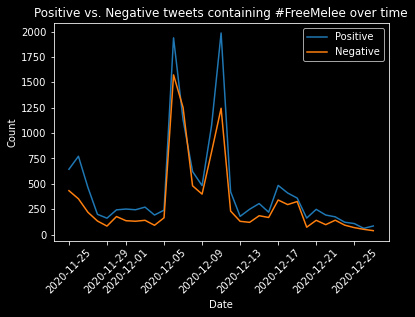

In [30]:
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# Create a column that extracts the month, date, and year from the date column
free_melee_df["day"] = free_melee_df["date"].apply(lambda x: datetime.datetime.strptime(str(x)[0:10], "%Y-%m-%d"))
# Create two dataframes, one for tweets classified as Positive and one for Negative
pos_free_melee = free_melee_df[free_melee_df["sentiment"] == "POS"]
neg_free_melee = free_melee_df[free_melee_df["sentiment"] == "NEG"]

# Group each frame by day
pos_group = pos_free_melee.groupby('day')
neg_group = neg_free_melee.groupby('day')

# Count the number of tweets in each frame per day
pos_free_melee_count = pos_group['sentiment'].count()
neg_free_melee_count = neg_group['sentiment'].count()

dates = pos_free_melee_count.index.tolist()
# Plot the positive and negative tweets over time
sns.lineplot(y= pos_free_melee_count.tolist(), x= dates)
sns.lineplot(y= neg_free_melee_count.tolist(), x= dates)
plt.xticks(rotation= 45)
plt.legend(labels= ["Positive","Negative"])
plt.title("Positive vs. Negative tweets containing #FreeMelee over time")
plt.xlabel("Date")
plt.ylabel("Count")

plt.show()

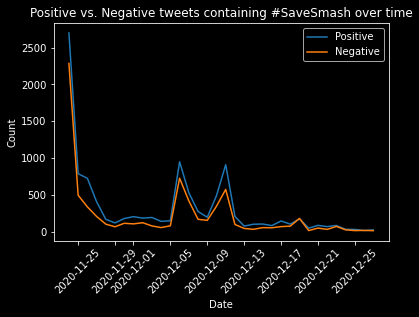

In [31]:
# Similar process, plot the #SaveSmash tweets over time
save_smash_df["day"] = save_smash_df["date"].apply(lambda x: datetime.datetime.strptime(str(x)[0:10], "%Y-%m-%d"))
pos_save_smash = save_smash_df[save_smash_df["sentiment"] == "POS"]
neg_save_smash = save_smash_df[save_smash_df["sentiment"] == "NEG"]

pos_group = pos_save_smash.groupby('day')
neg_group = neg_save_smash.groupby('day')

pos_save_smash_count = pos_group['sentiment'].count()
neg_save_smash_count = neg_group['sentiment'].count()

dates = pos_save_smash_count.index.tolist()

sns.lineplot(y= pos_save_smash_count.tolist(), x= dates)
sns.lineplot(y= neg_save_smash_count.tolist(), x= dates)
plt.xticks(rotation= 45)
plt.legend(labels= ["Positive","Negative"])
plt.title("Positive vs. Negative tweets containing #SaveSmash over time")
plt.xlabel("Date")
plt.ylabel("Count")

plt.show()

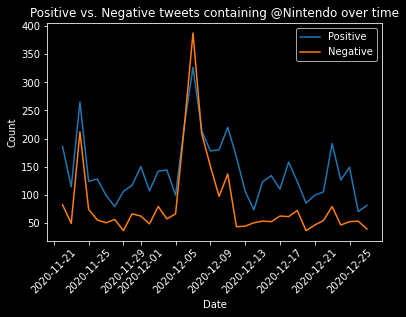

In [32]:
# Similar process, plot the tweets containing @Nintendo over time
mentions_df["day"] = mentions_df["date"].apply(lambda x: datetime.datetime.strptime(str(x)[0:10], "%Y-%m-%d"))
pos_mentions = mentions_df[mentions_df["sentiment"] == "POS"]
neg_mentions = mentions_df[mentions_df["sentiment"] == "NEG"]

pos_group = pos_mentions.groupby('day')
neg_group = neg_mentions.groupby('day')

pos_mentions_count = pos_group['sentiment'].count()
neg_mentions_count = neg_group['sentiment'].count()

dates = pos_mentions_count.index.tolist()

sns.lineplot(y= pos_mentions_count.tolist(), x= dates)
sns.lineplot(y= neg_mentions_count.tolist(), x= dates)
plt.xticks(rotation= 45)
plt.legend(labels= ["Positive","Negative"])
plt.title("Positive vs. Negative tweets containing @Nintendo over time")
plt.xlabel("Date")
plt.ylabel("Count")

plt.show()

Across the three sentiment plots showing the positive/negative tweets overtime, they show that at the beginning of our selected time period following the news regarding Nintendo's cease and desist, there is an increased number of negative tweets compared to several weeks after the news. Additionally, in all three plots we see the number of positive AND negative tweets increase around December 7th-12th which is when Sephiroth was announced. The number of negative tweets during this time period remained lower than the number of positive tweets in the #FreeMelee and #SaveSmash plots. However, one point during the interval on the @Nintendo plot shows a larger number of negative tweets. We will need to do further analysis to determine if this was a significant data point during the event.

Here, we performed a hypothesis test to determine if the difference between the number of positive and negative tweets during the time period of December 7th-12th is statistically significant, since based on the plots they follow a very similar trend. Since this is a binary classification, we performed a binomial test where x= Proportion of Positive tweets predicted by the model. We predicted by looking at the above plots that there will be significantly more Positive tweets in this interval.

x = Proportion of Positive tweets
H_0: x = 0.5 (no difference in amount of Positive vs. Negative tweets)
H_A: x > 0.5

Alpha level: 0.05

In [33]:
from scipy.stats import binom_test

# Count the number of tweets in the date interval for the #FreeMelee frame
fm_start = free_melee_df["day"] >= pd.to_datetime('2020-12-07')
fm_end = free_melee_df["day"] <= pd.to_datetime('2020-12-12')
fm_range = free_melee_df[fm_start & fm_end]
fm_total = fm_range["sentiment"].count()
fm_pos_range = fm_range[fm_range["sentiment"] == "POS"]
fm_pos_total = fm_pos_range["sentiment"].count()

# Count the number of tweets in the date interval for the #SaveSmash frame
ss_start = save_smash_df["day"] >= pd.to_datetime('2020-12-07')
ss_end = save_smash_df["day"] <= pd.to_datetime('2020-12-12')
ss_range = save_smash_df[ss_start & ss_end]
ss_total = ss_range["sentiment"].count()
ss_pos_range = ss_range[ss_range["sentiment"] == "POS"]
ss_pos_total = ss_pos_range["sentiment"].count()

# Count the number of tweets in the date interval for the @Nintendo frame
m_start = mentions_df["day"] >= pd.to_datetime('2020-12-07')
m_end = mentions_df["day"] <= pd.to_datetime('2020-12-12')
m_range = mentions_df[m_start & m_end]
m_total = m_range["sentiment"].count()
m_pos_range = m_range[m_range["sentiment"] == "POS"]
m_pos_total = m_pos_range["sentiment"].count()

# Perform a binomial test for each dataframe to determine if there is a significantly
# larger number of positive tweets than negative
fm_p = binom_test(x=fm_pos_total, n=fm_total, p=0.5, alternative='greater')
ss_p = binom_test(x=ss_pos_total, n=ss_total, p=0.5, alternative='greater')
m_p = binom_test(x=m_pos_total, n=m_total, p=0.5, alternative='greater')
print("p-value for #FreeMelee tweets: " + str(fm_p))
print("p-value for #SaveSmash tweets: " + str(ss_p))
print("p-value for @Nintendo tweets: " + str(m_p))

p-value for #FreeMelee tweets: 2.904630201018923e-38
p-value for #SaveSmash tweets: 5.534417367842273e-38
p-value for @Nintendo tweets: 3.08174564891761e-08


Since the p-value for each of the three dataframes is less than 0.05, we have sufficient evidence to reject the null hypothesis and say that the proportion of Positive tweets is significantly greater than Negative tweets in the chosen time interval. Though the trained model tends to have a slight skew towards Positive classifications as shown earlier, the calculated p-value is much lower than our alpha level which is likely not solely a result of the model's slight bias.


## Part 10: Final Thoughts

The purpose of training a model for sentiment classification was to determine if the *Super Smash Bros.* esports community had a sustained and significant Positive or Negative reaction on Twitter following the announcement of a popular character. We found that despite the negative attention and online anti-Nintendo movement occurring only weeks prior to Sephiroth's release, the tweets posted surrounding the event was significantly more Positive showcasing that the overall attitude towards the company remained positive. This conclusion also shows that the efforts made by members of the community to enact social change by protesting Nintendo's actions was not sustained and may be evidence to suggest that social media is not an effective vehicle for creating lasting change in corporate behavior.

In [35]:
!jupyter nbconvert --to html twitter.ipynb --HTMLExporter.theme=dark

[NbConvertApp] Converting notebook twitter.ipynb to html
[NbConvertApp] Writing 1051934 bytes to twitter.html
